In [1]:
import os
import numpy as np
import h5py
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
import csv
import cv2

import albumentations as A
from datetime import datetime
from tqdm import tqdm
from PIL import Image


# Scikit-learn imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, top_k_accuracy_score, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from torchvision import transforms

d:\Github\Bird-Recognition\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
species = ['Carduelis_carduelis','Ciconia_ciconia', 'Columba_livia',
              'Delichon_urbicum', 'Emberiza_calandra', 'Hirundo_rustica',
              'Passer_domesticus', 'Serinus_serinus', 'Streptopelia_decaocto',
              'Sturnus_unicolor', 'Turdus_merula']

train_transform = A.Compose([
    A.RandomResizedCrop(
        size=(224,224),
        scale=(0.8, 1.0),
    ),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=20,
        p=0.7
    ),
    A.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05,
        p=0.8
    ),
    A.CoarseDropout(
        max_holes=1,
        max_height=48,
        max_width=48,
        p=0.4
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    A.pytorch.ToTensorV2()
])

d:\Github\Bird-Recognition\.venv\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\PC-Master\AppData\Local\Temp\ipykernel_1700\3362888967.py:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [ ]:
MODEL_SAVE_DIR = 'saved_models/full_image_model'
RESULT_DIR = 'images'  
DATA_DIR = "datasets/full_image_dataset"
DATASET = 'dataset_20250603.h5'
BATCH_SIZE = [32]
N_SPLITS = 5                            
NUM_EPOCHS = 25
NUM_CLASSES = len(species)

In [4]:
def openH5File(filepath, fold_idx, include_test=False):
    file = h5py.File(filepath, 'r')
    datasets = {}

    if fold_idx is not None:
        try:
            fold_group = file[f'cross_validation/fold_{fold_idx}']
            datasets['X_train'] = fold_group['X_train'][:] 
            datasets['y_train'] = fold_group['y_train'][:]
            datasets['X_val'] = fold_group['X_val'][:]
            datasets['y_val'] = fold_group['y_val'][:]
        except KeyError:
            file.close()
            raise ValueError(f"Fold {fold_idx} not found")
    else:
        datasets['X_train'] = file['train']['X_train'][:]
        datasets['y_train'] = file['train']['y_train'][:]
        datasets['X_val'] = file['val']['X_val'][:]
        datasets['y_val'] = file['val']['y_val'][:]

    if include_test:
        datasets['X_test'] = file['test']['X_test'][:]
        datasets['y_test'] = file['test']['y_test'][:]

    file.close()
    return datasets

def applyTransforms(X, transform):
    X_aug = [transform(image=img)["image"] for img in X]
    return torch.stack(X_aug)

def createDataloaders(X, y, batch_size, shuffle=False, transform=None):
    if X.ndim == 4 and X.shape[-1] in {1, 3}:
        if transform:
            X_tensor = applyTransforms(X, transform)
             
    y_tensor = torch.from_numpy(y).long()
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size, shuffle, num_workers=4, pin_memory=True, persistent_workers=True)


def getDataloaders(filepath, fold_idx, batch_size, include_test=False):
    dataset = openH5File(filepath, fold_idx, include_test)
    train_loader, val_loader, test_loader = None, None, None

    if fold_idx is not None:
        # Cross-validation mode (train/val only)
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size, shuffle=True, transform=train_transform)
        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size, shuffle=False, transform=val_transform)
    else:
        # Full dataset mode
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size, shuffle=True, transform=train_transform)
        if include_test:
            X_combined = np.concatenate([dataset['X_val'], dataset['X_test']], axis=0)
            y_combined = np.concatenate([dataset['y_val'], dataset['y_test']], axis=0)
            test_loader = createDataloaders(X_combined, y_combined, batch_size, transform=val_transform)
    return train_loader, val_loader, test_loader


In [5]:
def getModel(name, nClasses, dropout_rate=0):
    if name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
        target_layer = "features.8"
    elif name == 'efficientnet_V2':
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
        target_layer = "features.7"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(DEVICE), target_layer

def getOptimizer(model, params):
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    return optimizer

In [6]:
def trainModel(model, train_loader, val_loader, params, num_epochs=NUM_EPOCHS, final_train=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=params.get('label_smoothing', 0.0))
    optimizer = getOptimizer(model, params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) if params.get('scheduler') else None

    # Early stopping setup
    best_f1 = 0
    improvementCounter = 0
    THRESHOLD = 5

    # History
    history = {'train_loss': [], 'train_acc': []}
    if not final_train:
        history.update({'val_loss': [], 'val_acc': [], 'val_f1': []})

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        if final_train:
            # Skip validation
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            continue  

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= max(1, len(all_labels))
        val_acc = val_corrects.double() / max(1, len(all_labels))
        val_f1 = f1_score(all_labels, all_preds, average='weighted') if all_preds else 0.0

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)

        if scheduler:
            scheduler.step(val_loss)

        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            improvementCounter = 0
        else:
            improvementCounter += 1
            if improvementCounter >= THRESHOLD:
                print("Early stopping triggered.")
                break

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    return history, best_f1 if not final_train else None

In [7]:

def preprocessImage(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0) 
    return img

def getClassLabel(preds):
    _, class_idx = torch.max(preds, 1)
    return class_idx.item()

def getConvLayer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Layer {conv_layer_name} not found in model.")

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1-alpha, 0)
    return superimposed_img

def computeGradCam(model, img_tensor, class_idx, conv_layer_name):
    conv_layer_name = getConvLayer(model, conv_layer_name)

    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
    
    hook = conv_layer_name.register_forward_hook(forward_hook)

    img_tensor.requires_grad_(True)
    preds = model(img_tensor)
    loss = preds[:, class_idx]
    model.zero_grad()
    loss.backward()

    grads = img_tensor.grad.cpu().numpy()
    pooled_grads = np.mean(grads, axis=(0, 2, 3))

    hook.remove()

    activations = activations.detach().cpu().numpy()[0]
    for i in range(len(pooled_grads)):
        activations[i, :] *= pooled_grads[i]
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def genGRADCAM(model, target_layer, test_loader, species_list):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    cam_results = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(inputs.size(0)):
            class_idx = labels[i].item()
            img_tensor = inputs[i].unsqueeze(0)

            original_img_path_jpg = f"{DATA_DIR}/{species_list[class_idx]}/{species_list[class_idx]}_{i}.jpg"
            original_img_path_jpeg = f"{DATA_DIR}/{species_list[class_idx]}/{species_list[class_idx]}_{i}.jpeg"

            if os.path.exists(original_img_path_jpg):
                original_img_path = original_img_path_jpg
            elif os.path.exists(original_img_path_jpeg):
                original_img_path = original_img_path_jpeg
            original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            heatmap = computeGradCam(model, img_tensor, class_idx, target_layer)
            output_img = overlay_heatmap(original_img_path, heatmap)

            cam_results.append({
                'class_name': species_list[class_idx],
                'image': output_img[..., ::-1],  # BGR to RGB
                'original': original_img_rgb  
            })

            # Just one per class (optional early stop)
            if len(cam_results) >= len(species_list):
                return cam_results

    return cam_results


def saveGRADCAM(gradcam_results, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for result in gradcam_results:
        filename = f"gradcam_{result['class_name']}.png"
        image = result['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8)) if image.max() <= 1.0 else Image.fromarray(image)
        image.save(os.path.join(save_dir, filename))


def plotGRADCAM(gradcam_results, save_path):
    cols = NUM_CLASSES
    rows = 2 

    plt.figure(figsize=(5 * cols, 5 * rows))
    
    for i, result in enumerate(gradcam_results):
        # Original image (first row)
        plt.subplot(rows, cols, i + 1) 
        plt.imshow(result['original'])
        plt.title(f"{result['class_name']}")
        plt.axis('off')

        # Grad-CAM image (second row)
        plt.subplot(rows, cols, cols + i + 1)
        plt.imshow(result['image'])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


def plotting(history, cm, metrics_dict, species, cam_images=None):
    # Plot training and evaluation graphs
    plot_path_graphs = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"final_graphs_{datetime.now().strftime('%Y%m%d')}.png")
    grad_path = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"gradcams_{datetime.now().strftime('%Y%m%d')}.png")
    fig1 = plt.figure(figsize=(24, 8))

    # Training history
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    if 'val_loss' in history and any(history['val_loss']):
        plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Confusion matrix
    if cm is not None:
        plt.subplot(1, 3, 2)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=species, yticklabels=species)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    # Precision-recall
    if metrics_dict is not None and 'recall' in metrics_dict and 'precision' in metrics_dict:
        plt.subplot(1, 3, 3)
        plt.plot(metrics_dict['recall'], metrics_dict['precision'], lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall (AUPRC: {metrics_dict.get("macro_auprc", 0.0):.4f})')

    plt.tight_layout()
    plt.savefig(plot_path_graphs, dpi=300)
    plt.close(fig1)

    # Plot Grad-CAMs
    if cam_images:
        plotGRADCAM(cam_images, grad_path)


In [8]:
def gridSearch(filepath, n_splits, hyperparams):
    results_log = {
        "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S"),
        "total_combinations": len(list(itertools.product(*hyperparams.values()))),
        "best_f1": 0,
        "best_params": None,
        "all_results": []
    }

    # Generate all possible hyperparameter combinations
    param_combinations = [dict(zip(hyperparams.keys(), v)) 
                         for v in itertools.product(*hyperparams.values())]
    print(f"\nBeginning GridSearch with {len(param_combinations)} combinations...")
    
    for params in tqdm(param_combinations):
        #torch.cuda.reset_peak_memory_stats()
        print("\n" + "="*50)
        print(f"Testing combination: {params}")
        fold_f1_scores = []
        fold_acc_scores = []
        start_time = time.time()
        memory_tracker = []
        
        # Cross-validation loop
        for fold_idx in range(1, n_splits+1):
            torch.cuda.empty_cache()
            gc.collect()
            
            train_loader, val_loader, _ = getDataloaders(filepath, fold_idx, params['batch_size'], False)
            model, _ = getModel(params['model_name'], NUM_CLASSES, params.get('dropout_rate', 0))
            history, fold_f1 = trainModel(model, train_loader, val_loader, params)
            print(f"Fold {fold_idx} Best F1 Score: {fold_f1:.4f}")
            fold_f1_scores.append(fold_f1)
            fold_acc_scores.append(history['val_acc'][-1].item())
            memory_tracker.append(torch.cuda.max_memory_allocated()/1e9)

            # Clean up
            del model, train_loader, val_loader
            torch.cuda.empty_cache()
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(fold_f1_scores)
        std_f1 = np.std(fold_f1_scores)
        avg_acc = np.mean(fold_acc_scores)
        std_acc = np.std(fold_acc_scores)
        time_taken = time.time() - start_time
        avg_memory = np.mean(memory_tracker)

        # Record this combination's results
        result_entry = {
            "params": params,
            "avg_f1": avg_f1,
            "std_f1": std_f1,
            "mean_acc": avg_acc,
            "std_acc": std_acc,
            "f1_scores": fold_f1_scores,
            "acc_scores": fold_acc_scores,
            "memory_used_GB": avg_memory,
            "time_taken": time_taken
        }
        results_log["all_results"].append(result_entry)
        
        # Update best parameters if improved
        if avg_f1 > results_log["best_f1"]:
            results_log["best_f1"] = avg_f1
            results_log["best_params"] = params
            print(f"New best parameters found with F1: {avg_f1:.4f}")

    # Finalize results        
    print("\nGridSearch completed!")
    torch.save(results_log["best_params"], os.path.join(MODEL_SAVE_DIR, f'gridsearch_setup1_{datetime.now().strftime("%Y%m%d")}.pth'))

    # Save JSON log
    json_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.json")
    with open(json_path, 'w') as f:
        json.dump(results_log, f, indent=4)

    # Save CSV results
    csv_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        header = ["params", "avg_f1", "std_f1", "mean_acc", "std_acc", "f1_scores", "acc_scores", "memory_used_GB", "time_taken"]
        writer.writerow(header)
        for res in results_log["all_results"]:
            writer.writerow([
                str(res["params"]), res["avg_f1"], res["std_f1"],
                res["mean_acc"], res["std_acc"],
                res["f1_scores"], res["acc_scores"],
                res["memory_used_GB"], res["time_taken"]
            ])

def bestTrainModel(filepath, best_params):
    model, target_layer = getModel(best_params['model_name'], nClasses=NUM_CLASSES, dropout_rate=best_params['dropout_rate'])
    train_loader, _ , test_loader = getDataloaders(filepath, None, best_params['batch_size'], True)
    history, _ = trainModel(model, train_loader, test_loader, best_params, final_train=True)

    # Generate Grad-CAMs
    cam_images = genGRADCAM(model, target_layer, test_loader, species)
    saveGRADCAM(cam_images, os.path.join(MODEL_SAVE_DIR, RESULT_DIR))

    # Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    criterion = nn.CrossEntropyLoss()
    test_loss, total_samples = 0.0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    labels_range = list(range(NUM_CLASSES))

    cm = confusion_matrix(all_labels, all_preds)
    binarized_labels = label_binarize(all_labels, classes=labels_range)
    precision, recall, _ = precision_recall_curve(binarized_labels[:, 0], all_probs[:, 0])

    metrics = {
        'test_loss': float(test_loss / total_samples),
        'top1_accuracy': float(accuracy_score(all_labels, all_preds)),
        'top3_accuracy': float(top_k_accuracy_score(all_labels, all_probs, k=3, labels=labels_range)),
        'f1_score': float(f1_score(all_labels, all_preds, average='weighted')),
        'confusion_matrix': cm.tolist(), 
        'macro_auprc': float(roc_auc_score(binarized_labels, all_probs, average='macro', multi_class='ovr')),
        'precision': precision.tolist(), 
        'recall': recall.tolist(),      
    }

    # Save model state dict and metadata
    final_model_path = os.path.join(MODEL_SAVE_DIR, f"final_model_{datetime.now().strftime("%Y%m%d")}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_name': best_params['model_name'],
        'best_params': best_params,
        'num_classes': NUM_CLASSES,
        'class_names': species,
        'metrics': metrics,
        'training_history': history
    }, final_model_path)
    
    # Save confusion matrix separately as numpy file
    np.save(os.path.join(MODEL_SAVE_DIR, f"confusion_matrix_{datetime.now().strftime('%Y%m%d')}.npy"), cm)
    
    # Now this will work:
    with open(os.path.join(MODEL_SAVE_DIR, f'final_metrics_{datetime.now().strftime("%Y%m%d")}.json'), 'w') as f:
        json.dump(metrics, f, indent=2)

    
    return model, history, metrics, cam_images 

In [9]:
# Main execution
# 1. Perform hyperparameter search
params = {
    'model_name': ['efficientnet_b0', 'efficientnet_V2'],
    'learning_rate': [0.0005, 0.0001],
    'batch_size': BATCH_SIZE,
    'weight_decay': [0.0001, 0],
    'optimizer': ['adamw'],
    'scheduler': [True],
    'dropout_rate': [0, 0.2]
}

# Ensure directories exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(MODEL_SAVE_DIR, RESULT_DIR), exist_ok=True)

#gridSearch(f"{DATA_DIR}/{DATASET}", N_SPLITS, params)

In [10]:
BEST_PARAMS = 'gridsearch_setup1_20250524.pth'
best_params = torch.load(os.path.join(MODEL_SAVE_DIR, BEST_PARAMS))
best_model, best_history, best_metrics, best_camImages = bestTrainModel(f"{DATA_DIR}/{DATASET}", best_params)
speciesModel = best_model.species if hasattr(best_model, 'species') else species

#Generate confusion matrix
cm = best_metrics['confusion_matrix']
        
#Plot results
plotting(
    history=best_history,
    cm=cm,
    metrics_dict=best_metrics,
    species=speciesModel,
    cam_images=best_camImages
)

Epoch 1/25 - Train Loss: 1.5729 Acc: 0.5151
Epoch 2/25 - Train Loss: 0.6209 Acc: 0.8079
Epoch 3/25 - Train Loss: 0.2696 Acc: 0.9217
Epoch 4/25 - Train Loss: 0.1344 Acc: 0.9602
Epoch 5/25 - Train Loss: 0.0965 Acc: 0.9693
Epoch 6/25 - Train Loss: 0.0640 Acc: 0.9819
Epoch 7/25 - Train Loss: 0.0584 Acc: 0.9835
Epoch 8/25 - Train Loss: 0.0657 Acc: 0.9812
Epoch 9/25 - Train Loss: 0.0551 Acc: 0.9840
Epoch 10/25 - Train Loss: 0.0454 Acc: 0.9867
Epoch 11/25 - Train Loss: 0.0311 Acc: 0.9922
Epoch 12/25 - Train Loss: 0.0518 Acc: 0.9865
Epoch 13/25 - Train Loss: 0.0475 Acc: 0.9867
Epoch 14/25 - Train Loss: 0.0338 Acc: 0.9906
Epoch 15/25 - Train Loss: 0.0261 Acc: 0.9915
Epoch 16/25 - Train Loss: 0.0290 Acc: 0.9920
Epoch 17/25 - Train Loss: 0.0263 Acc: 0.9940
Epoch 18/25 - Train Loss: 0.0352 Acc: 0.9906
Epoch 19/25 - Train Loss: 0.0193 Acc: 0.9952
Epoch 20/25 - Train Loss: 0.0149 Acc: 0.9957
Epoch 21/25 - Train Loss: 0.0193 Acc: 0.9938
Epoch 22/25 - Train Loss: 0.0261 Acc: 0.9936
Epoch 23/25 - Train


Classification Report:

                       precision    recall  f1-score   support

  Carduelis_carduelis       0.93      0.90      0.92       589
      Ciconia_ciconia       0.98      0.96      0.97       590
        Columba_livia       0.93      0.94      0.94       588
     Delichon_urbicum       0.90      0.93      0.91       558
    Emberiza_calandra       0.91      0.92      0.92       582
      Hirundo_rustica       0.94      0.87      0.90       557
    Passer_domesticus       0.89      0.96      0.92       559
      Serinus_serinus       0.88      0.91      0.89       573
Streptopelia_decaocto       0.95      0.95      0.95       578
     Sturnus_unicolor       0.95      0.95      0.95       550
        Turdus_merula       0.96      0.93      0.95       513

             accuracy                           0.93      6237
            macro avg       0.93      0.93      0.93      6237
         weighted avg       0.93      0.93      0.93      6237



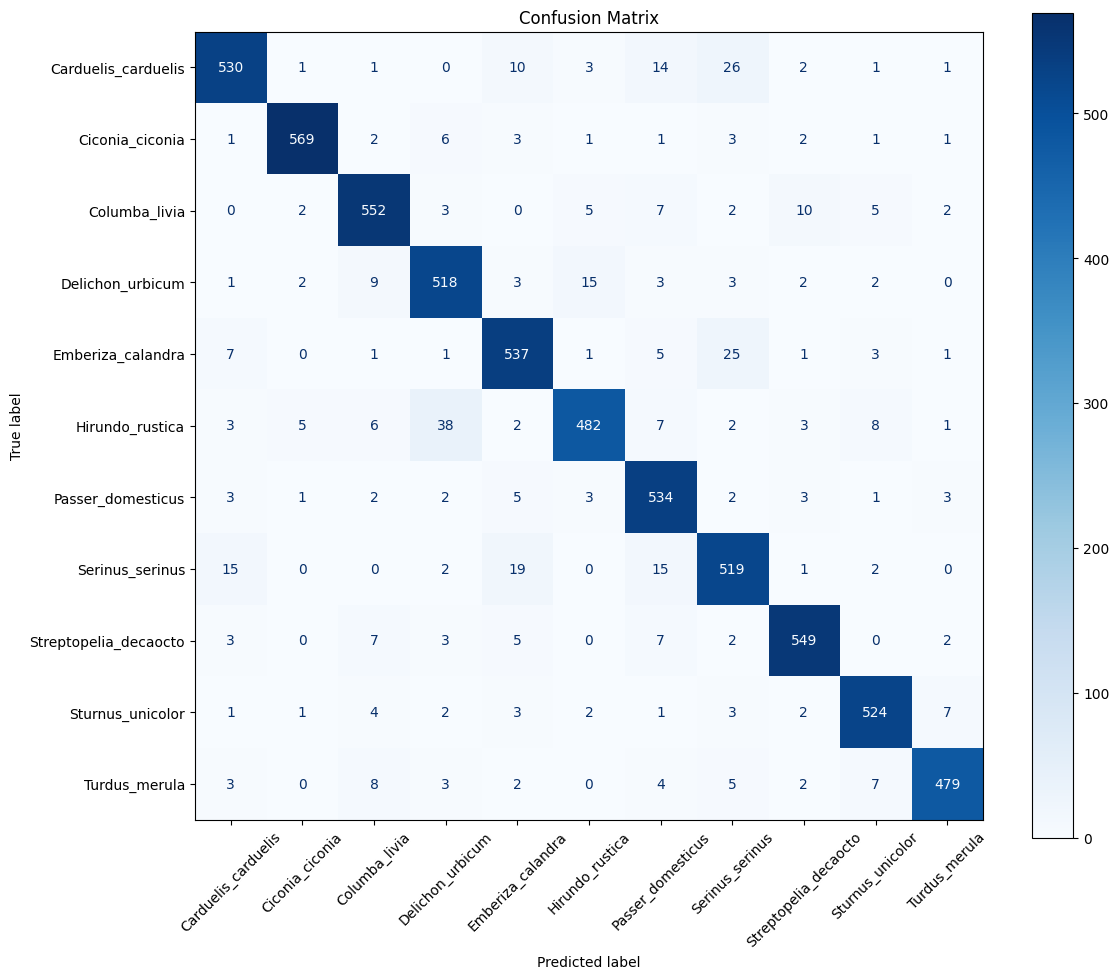


Sample Predictions:
Sample 3637: True = Passer_domesticus, Predicted = Passer_domesticus
Sample 1539: True = Columba_livia, Predicted = Columba_livia
Sample 185: True = Carduelis_carduelis, Predicted = Serinus_serinus
Sample 6025: True = Turdus_merula, Predicted = Turdus_merula
Sample 5981: True = Turdus_merula, Predicted = Turdus_merula


In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

clean_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def loadTrainedModel(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu' if not torch.cuda.is_available() else 'cuda'))
    model = getModel(
        checkpoint['best_params']['model_name'],
        nClasses=checkpoint['best_params'].get('num_classes', len(checkpoint['class_names'])),
        dropout_rate=checkpoint['best_params'].get('dropout_rate', 0.3))[0]
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, checkpoint


def show_classification_results(model, dataloader, class_names, device='cuda'):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Optional: show a few correct and incorrect predictions
    print("\nSample Predictions:")
    for idx in np.random.choice(len(all_preds), size=5, replace=False):
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]
        print(f"Sample {idx}: True = {true_label}, Predicted = {pred_label}")

        
FINALMODEL = 'final_model_20250604.pth'
model, checkpoint = loadTrainedModel(os.path.join(MODEL_SAVE_DIR, FINALMODEL))
test_dataset_clean = ImageFolder(root=DATA_DIR, transform=clean_transform)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False)
class_names = test_dataset_clean.classes
show_classification_results(model, test_loader_clean, class_names, device='cuda')